# Dynamics 365 Business Central Troubleshooting Guide (TSG) - Performance analysis (partner code issues)

This notebook contains Kusto queries that can help getting to the root cause of a performance issue for an environment. While we can provide some guidelines, there does not exist any exact formulas to determine if the data a given section is a problem or if this is normal behavior. 

  

The notebook highlights issues for object ids in the ranges defined for partner code \[50000..99999\] and \[1 mio..75 mio\] and can be used to find performance problems in code in per-tenant extensions or app source extensions.

Each section in the notebook contains links to the performance tuning guide on docs [aka.ms/bcperformance](..\..\D365BC%20Troubleshooting%20Guides%20(TSG)\content\aka.ms\bcperformance), links to the documentation of relevant telemetry in [aka.ms/bctelemetry](..\..\D365BC%20Troubleshooting%20Guides%20(TSG)\content\aka.ms\bctelemetry), as well as Kusto queries that help dive into a specific area (sessions, web service requests, database calls, reports, and page load times).

NB! Some of the signal used in this notebook is only available in newer versions of Business Central, so check the version of your environment if some sections do not return any data. The signal documentation states in which version a given signal was introduced.

## 1\. Get setup: Load up Python libraries and connect to Application Insights

First you need to set the notebook Kernel to Python3, load the KQLmagic module (did you install it? Install instructions: https://github.com/microsoft/BCTech/tree/master/samples/AppInsights/TroubleShootingGuides) and connect to your Application Insights resource (get appid and appkey from the API access page in the Application Insights portal)


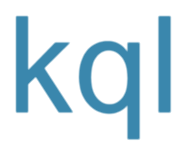

In [5]:
# load the KQLmagic module
%reload_ext Kqlmagic

In [6]:
# Connect to the Application Insights API
%kql appinsights://appid='<add app id from the Application Insights portal>';appkey='<add API key from the Application Insights portal>'

## 2\. Define filters

This workbook is designed for troubleshooting a single environment. Please provide values for aadTenantId, environmentName, and extensionId (or use a config file).

In [7]:
# Add values for AAD tenant id, environment name, and extension id here
# It is possible to leave the value for AAD tenant id or environment name blank (if you want to analyze across all values of the parameter)

# You can either use configuration file (INI file format) or set filters directly. 

# If you specify a config file, then variables set here takes precedence over manually set filter variables
# config file name and directory (full path)
configFile = "c:\\tmp\\notebook.ini"


# Add AAD tenant id and environment name here (or leave blank)
aadTenantId = ""
environmentName = ""
extensionId = ""

# date filters for the analysis
# use YYYY-MM-DD format for the dates (ISO 8601)
startDate = "2021-11-01"
endDate = "2022-01-01"




# Do not edit this code section
import configparser
config = configparser.ConfigParser()

config.read(configFile)

if bool(config.defaults()):
    if config.has_option('DEFAULT', 'aadTenantId'):
        aadTenantId = config['DEFAULT']['aadTenantId']
    if config.has_option('DEFAULT', 'environmentName'):
        environmentName = config['DEFAULT']['environmentName']
    if config.has_option('DEFAULT', 'extensionId'):
        extensionId = config['DEFAULT']['extensionId']
    if config.has_option('DEFAULT', 'startDate'):    
        startDate = config['DEFAULT']['startDate']
    if config.has_option('DEFAULT', 'endDate'):
        endDate = config['DEFAULT']['endDate']

print("Using these parameters for the analysis:")
print("----------------------------------------")
print("aadTenantId         " + aadTenantId)
print("environmentName     " + environmentName)
print("extensionId         " + extensionId)
print("startDate           " + startDate)
print("endDate             " + endDate)

Using these parameters for the analysis:
----------------------------------------
aadTenantId         
environmentName     
extensionId         
startDate           2021-11-01
endDate             2022-01-01


# Analyze performance
Now you can run Kusto queries to look for possible root causes for performance issues.

Either click **Run All** above to run all sections, or scroll down to the type of analysis you want to do and manually run queries

## Web service requests

Excessive amounts of incoming web service requests or web service requests that takes a long time to run can impact performance. 

Guidelines  

- If you see many calls using the SOAP protocol, consider moving towards OData or even APIs
- If you see web service calls that take 10+ seconds, consider if these calls can introduce locking (because this could cause UI sessions to be slower)
- If you see more than 5-10 web service calls per minut, consider if you can spread the calls out over the day instead (or check if you really need to call so frequent). 

Resources

- Performance tuning guide: [https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/performance/performance-developer#writing-efficient-web-services](https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/performance/performance-developer#writing-efficient-web-services)
- Web service telemetry docs: [https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-webservices-trace](https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-webservices-trace)
- KQL samples: [https://github.com/microsoft/BCTech/blob/master/samples/AppInsights/KQL/RawData/WebServiceCalls.kql](https://github.com/microsoft/BCTech/blob/master/samples/AppInsights/KQL/RawData/WebServiceCalls.kql)

In [8]:
%%kql
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
let _extensionId = extensionId;
let _startDate = startDate;
let _endDate = endDate;
traces
| where 1==1 
    and timestamp >= todatetime(_startDate)
    and timestamp <= todatetime(_endDate) + totimespan(24h) - totimespan(1ms)   
    and (_aadTenantId == '' or customDimensions.aadTenantId == _aadTenantId)
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and (_extensionId == '' or customDimensions.extensionId == _extensionId)    
    and customDimensions.eventId == 'RT0008'
| extend alObjectId = toint(customDimensions.alObjectId)
| where alObjectId between (50000 .. 99999) or alObjectId between (1000000 .. 74999999)
| extend category = tostring( customDimensions.category )
| extend codeOwnership = case(
      alObjectId between (50000 .. 99999), 'ENVIRONMENT'
    , alObjectId between (1000000 .. 69999999), 'ISV_ONPREM'
    , alObjectId between (70000000 .. 74999999), 'ISV_ONLINE'
    , 'MICROSOFT'
)
| summarize request_count=count() by category, bin(timestamp, 1d)
| render timechart title= 'Number of web service requests by category endpoints (in partner code)'

[]

In [9]:
%%kql
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
let _extensionId = extensionId;
let _startDate = startDate;
let _endDate = endDate;
traces
| where 1==1 
    and timestamp >= todatetime(_startDate)
    and timestamp <= todatetime(_endDate) + totimespan(24h) - totimespan(1ms)   
    and (_aadTenantId == '' or customDimensions.aadTenantId == _aadTenantId)
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and (_extensionId == '' or customDimensions.extensionId == _extensionId)    
    and customDimensions.eventId == 'RT0008'
| extend alObjectId = toint(customDimensions.alObjectId)
| where alObjectId between (50000 .. 99999) or alObjectId between (1000000 .. 74999999)
| extend category = tostring( customDimensions.category )
       , executionTimeInMS = toreal(totimespan(customDimensions.serverExecutionTime))/10000 //the datatype for executionTime is timespan 
| extend codeOwnership = case(
      alObjectId between (50000 .. 99999), 'ENVIRONMENT'
    , alObjectId between (1000000 .. 69999999), 'ISV_ONPREM'
    , alObjectId between (70000000 .. 74999999), 'ISV_ONLINE'
    , 'MICROSOFT'
)
| where executionTimeInMS <= 10000 // only include ws calls with execution time <= 10 sec
| summarize count() by executionTime_ms = bin(executionTimeInMS, 100), category
| extend log_count = log10(count_)
| order by category, executionTime_ms asc
| render columnchart with  (ycolumns = log_count, ytitle='Log10(count)', series = category, title= 'Execution time (in ms) of normal web service requests by category (in partner code)' ) 

[]

In [10]:
%%kql
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
let _extensionId = extensionId;
let _startDate = startDate;
let _endDate = endDate;
traces
| where 1==1 
    and timestamp >= todatetime(_startDate)
    and timestamp <= todatetime(_endDate) + totimespan(24h) - totimespan(1ms)   
    and (_aadTenantId == '' or customDimensions.aadTenantId == _aadTenantId)
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and (_extensionId == '' or customDimensions.extensionId == _extensionId)    
    and customDimensions.eventId == 'RT0008'
| extend alObjectId = toint(customDimensions.alObjectId)
| where alObjectId between (50000 .. 99999) or alObjectId between (1000000 .. 74999999)
| extend category = tostring( customDimensions.category )
       , executionTimeInSec = toreal(totimespan(customDimensions.serverExecutionTime))/10000 /1000 //the datatype for executionTime is timespan 
| extend codeOwnership = case(
      alObjectId between (50000 .. 99999), 'ENVIRONMENT'
    , alObjectId between (1000000 .. 69999999), 'ISV_ONPREM'
    , alObjectId between (70000000 .. 74999999), 'ISV_ONLINE'
    , 'MICROSOFT'
)
| where executionTimeInSec > 10 // only include ws calls with execution time > 10 sec
| summarize count() by executionTime_sec = bin(executionTimeInSec, 10), category
| extend log_count = log10(count_)
| order by category, executionTime_sec asc
| render columnchart with  (ycolumns = log_count, ytitle='log10(count)', series = category, title= 'Execution time (in sec) of slow web service requests by category (in partner code)' ) 

[]

In [11]:
%%kql
// 
// top 20 most expensive web service calls (partner code)
// 
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
let _extensionId = extensionId;
let _startDate = startDate;
let _endDate = endDate;
traces
| where 1==1 
    and timestamp >= todatetime(_startDate)
    and timestamp <= todatetime(_endDate) + totimespan(24h) - totimespan(1ms)   
    and (_aadTenantId == '' or customDimensions.aadTenantId == _aadTenantId)
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and (_extensionId == '' or customDimensions.extensionId == _extensionId)    
    and customDimensions.eventId == 'RT0008'
| extend alObjectId = toint(customDimensions.alObjectId)
| where alObjectId between (50000 .. 99999) or alObjectId between (1000000 .. 74999999)
| extend category = tostring( customDimensions.category )
       , endpoint = tostring( customDimensions.endpoint )
       , executionTimeInMS = toreal(totimespan(customDimensions.serverExecutionTime))/10000 //the datatype for executionTime is timespan 
| extend codeOwnership = case(
      alObjectId between (50000 .. 99999), 'ENVIRONMENT'
    , alObjectId between (1000000 .. 69999999), 'ISV_ONPREM'
    , alObjectId between (70000000 .. 74999999), 'ISV_ONLINE'
    , 'MICROSOFT'
)
| summarize count=count(), medianExecutionTimeInMS=percentile(executionTimeInMS, 50) by alObjectId, category, endpoint
| order by medianExecutionTimeInMS desc
| limit 20

,alObjectId,category,endpoint,count,medianExecutionTimeInMS


[]

## (Outgoing) web service requests overview 
Outgoing web service calls (calls to the HttpClient module from AL) are blocking calls with respect to AL execution. This means that the page will be unresponsive until the server receives a response from the remote service being called.
Guidelines  
- If you see outgoing calls with HTTP status codes outside the 2xx range, then this indicates an error either in the service being called or in the AL code calling it.
- If you see outgoing calls that take longer than a few seconds and if the code calling out is on a UI page, consider putting that call in a page background task to unblock the UI.
  
Resources
- Performance tuning guide: [https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/performance/performance-developer#web-service-client-performance](https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/performance/performance-developer#writing-efficient-web-services)
- Outgoing Web service telemetry docs: [https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-webservices-outgoing-trace](https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-webservices-outgoing-trace) 
- KQL sample: [https://github.com/microsoft/BCTech/blob/master/samples/AppInsights/KQL/RawData/OutGoingWebServiceCalls.kql](https://github.com/microsoft/BCTech/blob/master/samples/AppInsights/KQL/RawData/OutGoingWebServiceCalls.kql)
- Explanation of different HTTP status codes: [https://en.wikipedia.org/wiki/List\_of\_HTTP\_status\_codes](https://en.wikipedia.org/wiki/List_of_HTTP_status_codes)

In [12]:
%%kql
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
let _extensionId = extensionId;
let _startDate = startDate;
let _endDate = endDate;
traces
| where 1==1 
    and timestamp >= todatetime(_startDate)
    and timestamp <= todatetime(_endDate) + totimespan(24h) - totimespan(1ms)    
    and (_aadTenantId == '' or customDimensions.aadTenantId == _aadTenantId)
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and (_extensionId == '' or customDimensions.extensionId == _extensionId)    
    and customDimensions.eventId == 'RT0019'
| extend alObjectId = toint(customDimensions.alObjectId)    
| where alObjectId between (50000 .. 99999) or alObjectId between (1000000 .. 74999999)
| extend httpStatusCode = tostring( customDimensions.httpReturnCode )
| extend codeOwnership = case(
      alObjectId between (50000 .. 99999), 'ENVIRONMENT'
    , alObjectId between (1000000 .. 69999999), 'ISV_ONPREM'
    , alObjectId between (70000000 .. 74999999), 'ISV_ONLINE'
    , 'MICROSOFT'
)
| summarize request_count=count() by httpStatusCode, bin(timestamp, 1d)
| order by httpStatusCode asc
| render timechart title= 'Number of outgoing web service requests by HTTP status code (partner code)'

[]

In [13]:
%%kql
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
let _extensionId = extensionId;
let _startDate = startDate;
let _endDate = endDate;
traces
| where 1==1 
    and timestamp >= todatetime(_startDate)
    and timestamp <= todatetime(_endDate) + totimespan(24h) - totimespan(1ms)        
    and (_aadTenantId == '' or customDimensions.aadTenantId == _aadTenantId)
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and (_extensionId == '' or customDimensions.extensionId == _extensionId)    
    and customDimensions.eventId == 'RT0019'
| extend httpMethod = tostring( toupper( customDimensions.httpMethod ) )
       , executionTimeInSec = toreal(totimespan(customDimensions.serverExecutionTime))/10000 /1000 //the datatype for executionTime is timespan 
| extend alObjectId = toint(customDimensions.alObjectId)    
| where alObjectId between (50000 .. 99999) or alObjectId between (1000000 .. 74999999)
| extend httpStatusCode = tostring( customDimensions.httpReturnCode )
| extend codeOwnership = case(
      alObjectId between (50000 .. 99999), 'ENVIRONMENT'
    , alObjectId between (1000000 .. 69999999), 'ISV_ONPREM'
    , alObjectId between (70000000 .. 74999999), 'ISV_ONLINE'
    , 'MICROSOFT'
)
| where executionTimeInSec <= 10
| summarize count() by executionTime_sec = bin(executionTimeInSec, 1), httpMethod
| extend log_count = log10( count_ )
| order by httpMethod, executionTime_sec asc
| render columnchart with  (ycolumns = log_count, ytitle='log(count)', series = httpMethod, title= 'Execution time (seconds) of "normal" outgoing ws requests by method' ) 


[]

In [14]:
%%kql
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
let _extensionId = extensionId;
let _startDate = startDate;
let _endDate = endDate;
traces
| where 1==1 
    and timestamp >= todatetime(_startDate)
    and timestamp <= todatetime(_endDate) + totimespan(24h) - totimespan(1ms)        
    and (_aadTenantId == '' or customDimensions.aadTenantId == _aadTenantId)
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and (_extensionId == '' or customDimensions.extensionId == _extensionId)    
    and customDimensions.eventId == 'RT0019'
| extend httpMethod = tostring( toupper( customDimensions.httpMethod ) )
       , executionTimeInSec = toreal(totimespan(customDimensions.serverExecutionTime))/10000 /1000 //the datatype for executionTime is timespan 
| extend alObjectId = toint(customDimensions.alObjectId)    
| where alObjectId between (50000 .. 99999) or alObjectId between (1000000 .. 74999999)
| extend httpStatusCode = tostring( customDimensions.httpReturnCode )
| extend codeOwnership = case(
      alObjectId between (50000 .. 99999), 'ENVIRONMENT'
    , alObjectId between (1000000 .. 69999999), 'ISV_ONPREM'
    , alObjectId between (70000000 .. 74999999), 'ISV_ONLINE'
    , 'MICROSOFT'
)
| where executionTimeInSec > 10
| summarize count() by executionTime_sec = bin(executionTimeInSec, 10), httpMethod
| extend log_count = log10( count_ )
| order by httpMethod, executionTime_sec asc
| render columnchart with  (ycolumns = log_count, ytitle='log10(count)', series = httpMethod, title= 'Execution time (seconds) of slow outgoing ws requests by method' ) 


[]

In [15]:
%%kql
//
// Top 20 most expensive outgoing calls
//
// Includes descriptive statistics avg, min, max, and 95 percentile for execution time and number of calls
//
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
let _extensionId = extensionId;
let _startDate = startDate;
let _endDate = endDate;
traces
| where 1==1 
    and timestamp >= todatetime(_startDate)
    and timestamp <= todatetime(_endDate) + totimespan(24h) - totimespan(1ms)    
    and (_aadTenantId == '' or customDimensions.aadTenantId == _aadTenantId)
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and (_extensionId == '' or customDimensions.extensionId == _extensionId)    
    and customDimensions.eventId == 'RT0019'
| extend httpMethod = tostring( toupper( customDimensions.httpMethod ) )
       , executionTimeInMS = toreal(totimespan(customDimensions.serverExecutionTime))/10000 //the datatype for executionTime is timespan 
       , alObjectId = tostring( customDimensions.alObjectId )
       , alObjectName = tostring( customDimensions.alObjectName )
       , alObjectType = tostring( customDimensions.alObjectType )
, endpoint = tostring( customDimensions.endpoint )
, extensionId = tostring( customDimensions.extensionId )
, extensionName = tostring( customDimensions.extensionName )
, extensionVersion = tostring( customDimensions.extensionVersion )
| extend alObjectId = toint(customDimensions.alObjectId)    
| where alObjectId between (50000 .. 99999) or alObjectId between (1000000 .. 74999999)
| extend httpStatusCode = tostring( customDimensions.httpReturnCode )
| extend codeOwnership = case(
      alObjectId between (50000 .. 99999), 'ENVIRONMENT'
    , alObjectId between (1000000 .. 69999999), 'ISV_ONPREM'
    , alObjectId between (70000000 .. 74999999), 'ISV_ONLINE'
    , 'MICROSOFT'
)
| summarize avg(executionTimeInMS), min(executionTimeInMS), max(executionTimeInMS),percentile(executionTimeInMS,95), count() by 
  httpMethod
, alObjectId, alObjectName, alObjectType, codeOwnership
, extensionId, extensionName, extensionVersion
, endpoint
| order by avg_executionTimeInMS desc
| project avg_timeInSec=round(avg_executionTimeInMS/1000,2)
, min_timeInSec=round(min_executionTimeInMS/1000,2)
, max_timeInSec=round(max_executionTimeInMS/1000,2)
, perc_95InSec=round(percentile_executionTimeInMS_95/1000,2), count_
, alObjectId, alObjectName, alObjectType, codeOwnership
, extensionId, extensionName, extensionVersion, httpMethod, endpoint
| limit 20

,avg_timeInSec,min_timeInSec,max_timeInSec,perc_95InSec,count_,alObjectId,alObjectName,alObjectType,codeOwnership,extensionId,extensionName,extensionVersion,httpMethod,endpoint


[]

## Data related
A performance issue is in many cases caused by long running SQL queries or by database locking.
  
Guidelines
- If you see long running queries that take more than a few seconds and this happens on a UI page, consider if you can rewrite the AL code to be more effecient. Most users can tolerate a page load time that takes up to 5 seconds for list pages and up to 2 seconds for card pages.
- If you see database lock timeouts, this means that UI users see error messages. Try to find the code that takes the lock and rewrite it.
- The performance tuning guide (see links below) contain a lot of advice on how to tune data access.
  
Resources
- Performance tuning guide:
    
    - [Efficient data access](https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/performance/performance-developer#efficient-data-access)
    - [Avoid locking](https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/performance/performance-application#avoid-locking)
- Database telemetry docs
    
    - [https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-long-running-sql-query-trace](https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-long-running-sql-query-trace)
    - [https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-database-locks-trace](https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-database-locks-trace)
- Database telemetry
    
    - [https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-long-running-sql-query-trace](https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-long-running-sql-query-trace)
    - [https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-database-locks-trace](https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-database-locks-trace)

In [16]:
%%kql
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
let _extensionId = extensionId;
let _startDate = startDate;
let _endDate = endDate;
traces
| where 1==1 
    and timestamp >= todatetime(_startDate)
    and timestamp <= todatetime(_endDate) + totimespan(24h) - totimespan(1ms)   
    and (_aadTenantId == '' or customDimensions.aadTenantId == _aadTenantId)
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and (_extensionId == '' or customDimensions.extensionId == _extensionId)    
    and customDimensions.eventId == 'RT0005'
| extend alObjectId = toint(customDimensions.alObjectId)
| where alObjectId between (50000 .. 99999) or alObjectId between (1000000 .. 74999999)
| extend codeOwnership = case(
      alObjectId between (50000 .. 99999), 'ENVIRONMENT'
    , alObjectId between (1000000 .. 69999999), 'ISV_ONPREM'
    , alObjectId between (70000000 .. 74999999), 'ISV_ONLINE'
    , 'MICROSOFT'
)
| summarize count() by bin(timestamp, 1d)
| render timechart title= 'Number of long running SQL queries (in partner code)'

[]

In [17]:
%%kql
// 
// top 20 most expensive long running sql queries (in partner code)
// 
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
let _extensionId = extensionId;
let _startDate = startDate;
let _endDate = endDate;
traces
| where 1==1 
    and timestamp >= todatetime(_startDate)
    and timestamp <= todatetime(_endDate) + totimespan(24h) - totimespan(1ms)   
    and (_aadTenantId == '' or customDimensions.aadTenantId == _aadTenantId)
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and (_extensionId == '' or customDimensions.extensionId == _extensionId)    
    and customDimensions.eventId == 'RT0005'
| extend alObjectId = toint(customDimensions.alObjectId)
       , alObjectName = tostring(customDimensions.alObjectName)
       , extensionId = tostring( customDimensions.extensionId )
       , extensionName = tostring( customDimensions.extensionName )
       , extensionVersion = tostring( customDimensions.extensionVersion )       
       , executionTimeInSec = toreal(totimespan(customDimensions.executionTime))/10000/1000 //the datatype for executionTime is timespan 
| where alObjectId between (50000 .. 99999) or alObjectId between (1000000 .. 74999999)
| extend codeOwnership = case(
      alObjectId between (50000 .. 99999), 'ENVIRONMENT'
    , alObjectId between (1000000 .. 69999999), 'ISV_ONPREM'
    , alObjectId between (70000000 .. 74999999), 'ISV_ONLINE'
    , 'MICROSOFT'
)
| summarize count(), avg(executionTimeInSec) by objectId=alObjectId, objectName=alObjectName, extensionId, extensionName, extensionVersion, codeOwnership
| limit 20

,objectId,objectName,extensionId,extensionName,extensionVersion,codeOwnership,count_,avg_executionTimeInSec


[]

In [18]:
%%kql
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
let _extensionId = extensionId;
let _startDate = startDate;
let _endDate = endDate;
traces
| where 1==1 
    and timestamp >= todatetime(_startDate)
    and timestamp <= todatetime(_endDate) + totimespan(24h) - totimespan(1ms)   
    and (_aadTenantId == '' or customDimensions.aadTenantId == _aadTenantId)
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and (_extensionId == '' or customDimensions.extensionId == _extensionId)    
    and customDimensions.eventId == 'RT0012'
| extend alObjectId = toint(customDimensions.alObjectId)
| where alObjectId between (50000 .. 99999) or alObjectId between (1000000 .. 74999999)
| extend codeOwnership = case(
      alObjectId between (50000 .. 99999), 'ENVIRONMENT'
    , alObjectId between (1000000 .. 69999999), 'ISV_ONPREM'
    , alObjectId between (70000000 .. 74999999), 'ISV_ONLINE'
    , 'MICROSOFT'
)
| summarize request_count=count() by bin(timestamp, 1d)
| render timechart title= 'Number of database lock timeouts (in partner code)'

[]

In [19]:
%%kql
// 
// partner code units where database lock timeouts occur
// 
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
let _extensionId = extensionId;
let _startDate = startDate;
let _endDate = endDate;
traces
| where 1==1 
    and timestamp >= todatetime(_startDate)
    and timestamp <= todatetime(_endDate) + totimespan(24h) - totimespan(1ms)   
    and (_aadTenantId == '' or customDimensions.aadTenantId == _aadTenantId)
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and (_extensionId == '' or customDimensions.extensionId == _extensionId)    
    and customDimensions.eventId == 'RT0012'
| extend alObjectId = toint(customDimensions.alObjectId)
| where alObjectId between (50000 .. 99999) or alObjectId between (1000000 .. 74999999)
| extend codeOwnership = case(
      alObjectId between (50000 .. 99999), 'ENVIRONMENT'
    , alObjectId between (1000000 .. 69999999), 'ISV_ONPREM'
    , alObjectId between (70000000 .. 74999999), 'ISV_ONLINE'
    , 'MICROSOFT'
)
| summarize timeout_count=count() by alObjectId
| order by timeout_count

,alObjectId,timeout_count


[]

## Reports
Long running reports (running longer than 1 minute) is normally not a problem for a user, because a report is seen as something that can take some time. But reports can consume resources on both the server and the database.
Guidelines
- Check if Word/RDLC reports are configured to use _read scale-out._ This will help reduce locking issues caused by reports
- Check if there are excessive number of reports being run on the system (e.g. a report scheduled to run every minute instead of every hour)
  
Resources
- Learn more about how to write performant reports here in the performance tuning guide: [https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/performance/performance-developer#writing-efficient-reports](https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/performance/performance-developer#writing-efficient-reports)
- Report telemetry docs: [https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-reports-trace](https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-reports-trace)
- KQL samples:
    - [https://github.com/microsoft/BCTech/blob/master/samples/AppInsights/KQL/RawData/Reports.kql](https://github.com/microsoft/BCTech/blob/master/samples/AppInsights/KQL/RawData/Reports.kql)
    - [https://github.com/microsoft/BCTech/blob/master/samples/AppInsights/KQL/PerformanceTuning/ReportExecution.kql](https://github.com/microsoft/BCTech/blob/master/samples/AppInsights/KQL/PerformanceTuning/ReportExecution.kql)

In [20]:
%%kql
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
let _extensionId = extensionId;
let _startDate = startDate;
let _endDate = endDate;
traces
| where 1==1 
    and timestamp >= todatetime(_startDate)
    and timestamp <= todatetime(_endDate) + totimespan(24h) - totimespan(1ms)   
    and (_aadTenantId == '' or customDimensions.aadTenantId == _aadTenantId)
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and (_extensionId == '' or customDimensions.extensionId == _extensionId)    
    and customDimensions.eventId == 'RT0006'
| extend alObjectId = toint(customDimensions.alObjectId)
| where alObjectId between (50000 .. 99999) or alObjectId between (1000000 .. 74999999)
| extend clientType = tostring( customDimensions.clientType )
       , reportName = tostring( customDimensions.alObjectName )
| extend codeOwnership = case(
      alObjectId between (50000 .. 99999), 'ENVIRONMENT'
    , alObjectId between (1000000 .. 69999999), 'ISV_ONPREM'
    , alObjectId between (70000000 .. 74999999), 'ISV_ONLINE'
    , 'MICROSOFT'
)
| where reportName <> ''
| summarize count=count() by clientType, bin(timestamp, 1d)
| render timechart title= 'Number of report execution by client/session type (partner reports)'

[]

In [21]:
%%kql
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
let _extensionId = extensionId;
let _startDate = startDate;
let _endDate = endDate;
traces
| where 1==1 
    and timestamp >= todatetime(_startDate)
    and timestamp <= todatetime(_endDate) + totimespan(24h) - totimespan(1ms)   
    and (_aadTenantId == '' or customDimensions.aadTenantId == _aadTenantId)
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and (_extensionId == '' or customDimensions.extensionId == _extensionId)    
    and customDimensions.eventId == 'RT0006'
| extend alObjectId = toint(customDimensions.alObjectId)
| where alObjectId between (50000 .. 99999) or alObjectId between (1000000 .. 74999999)
| extend reportName = tostring( customDimensions.alObjectName )
       , executionTimeInSec = toreal(totimespan(customDimensions.totalTime))/10000000 //the datatype for executionTime is timespan 
| where reportName <> ''
| extend codeOwnership = case(
      alObjectId between (50000 .. 99999), 'ENVIRONMENT'
    , alObjectId between (1000000 .. 69999999), 'ISV_ONPREM'
    , alObjectId between (70000000 .. 74999999), 'ISV_ONLINE'
    , 'MICROSOFT'
)
| summarize avg=avg(executionTimeInSec), median=percentile(executionTimeInSec, 50), percentile95=percentile(executionTimeInSec, 95), max=max(executionTimeInSec)   
  by reportName
| order by percentile95
| limit 10
| render columnchart with  (title= 'Execution time stats of (partner) reports by report name (top 10 by 95% percentile)', ytitle='Time (in seconds)' ) 

[]

In [22]:
%%kql
// 
// top 20 most expensive reports (in partner code)
// 
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
let _extensionId = extensionId;
let _startDate = startDate;
let _endDate = endDate;
traces
| where 1==1 
    and timestamp >= todatetime(_startDate)
    and timestamp <= todatetime(_endDate) + totimespan(24h) - totimespan(1ms)   
    and (_aadTenantId == '' or customDimensions.aadTenantId == _aadTenantId)
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and (_extensionId == '' or customDimensions.extensionId == _extensionId)    
    and customDimensions.eventId == 'RT0006'
| extend alObjectId = toint(customDimensions.alObjectId)
| where alObjectId between (50000 .. 99999) or alObjectId between (1000000 .. 74999999)
| extend reportName = tostring( customDimensions.alObjectName )
       , executionTimeInSec = toreal(totimespan(customDimensions.totalTime))/10000000 //the datatype for executionTime is timespan 
| extend codeOwnership = case(
      alObjectId between (50000 .. 99999), 'ENVIRONMENT'
    , alObjectId between (1000000 .. 69999999), 'ISV_ONPREM'
    , alObjectId between (70000000 .. 74999999), 'ISV_ONLINE'
    , 'MICROSOFT'
)
| where reportName <> ''
| summarize avg=avg(executionTimeInSec), median=percentile(executionTimeInSec, 50), percentile95=percentile(executionTimeInSec, 95), max=max(executionTimeInSec)   
  by reportName
| order by percentile95
| limit 20

,reportName,avg,median,percentile95,max


[]

In [23]:
%%kql
// 
// top 10 reports that have a low sqlratio
// 
// The higher the number called sqlratio is, the more set-based the report is (it tells you how many sql rows are read per sql statement)
//
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
let _extensionId = extensionId;
let _startDate = startDate;
let _endDate = endDate;
traces
| where 1==1 
    and timestamp >= todatetime(_startDate)
    and timestamp <= todatetime(_endDate) + totimespan(24h) - totimespan(1ms)   
    and (_aadTenantId == '' or customDimensions.aadTenantId == _aadTenantId)
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and (_extensionId == '' or customDimensions.extensionId == _extensionId)    
    and customDimensions.eventId == 'RT0006'
| extend alObjectId = toint(customDimensions.alObjectId)
| where alObjectId between (50000 .. 99999) or alObjectId between (1000000 .. 74999999)
| extend codeOwnership = case(
      alObjectId between (50000 .. 99999), 'ENVIRONMENT'
    , alObjectId between (1000000 .. 69999999), 'ISV_ONPREM'
    , alObjectId between (70000000 .. 74999999), 'ISV_ONLINE'
    , 'MICROSOFT'
)
| project numberOfRows = toint(customDimensions.numberOfRows)
, sqlRowsRead = toint( customDimensions.sqlRowsRead )
, sqlExecutes = toint( customDimensions.sqlExecutes )
, alObjectName = tostring( customDimensions.alObjectName )
, alObjectId = tostring( customDimensions.alObjectId )
, codeOwnership
, extensionPublisher = tostring(customDimensions.extensionPublisher )
| where isnotnull( sqlExecutes ) and isnotnull( sqlRowsRead )
| summarize numberOfReportExecutions=count(), totalRows=sum(numberOfRows), totalSQLExecutes = sum(sqlExecutes), totalSQLRowsRead = sum(sqlRowsRead) 
by alObjectId, alObjectName, codeOwnership
| extend sqlratio = toreal(totalSQLRowsRead)/totalSQLExecutes
, datasetratio = toreal(totalRows)/totalSQLExecutes
| order by sqlratio asc
| limit 10

,alObjectId,alObjectName,codeOwnership,numberOfReportExecutions,totalRows,totalSQLExecutes,totalSQLRowsRead,sqlratio,datasetratio


[]

## Slow AL code (only available from version 17.1)
AL execution is normally very fast in itself. If you see data in this section, you might have implemented an in-efficient algorithm.
  
Guidelines
- It is unlikely that an AL method that only does AL (no calls to external web services or the database) executes for more than 1000 ms.
  
Resources
- Learn more about how to write performant AL code here in the performance tuning guide: [https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/performance/performance-developer#al-performance-patterns](https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/performance/performance-developer#al-performance-patterns)
- Long running AL method telemetry docs: [https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-al-method-trace](https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-al-method-trace)
- KQL samples:
    - [https://github.com/microsoft/BCTech/blob/master/samples/AppInsights/KQL/Queries/RawData/LongRunningAL.kq](https://github.com/microsoft/BCTech/blob/master/samples/AppInsights/KQL/Queries/RawData/LongRunningAL.kql)l
    - [https://github.com/microsoft/BCTech/blob/master/samples/AppInsights/KQL/Queries/PerformanceTuning/SlowALMethods.kql](https://github.com/microsoft/BCTech/blob/master/samples/AppInsights/KQL/Queries/PerformanceTuning/SlowALMethods.kql)

In [24]:
%%kql
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
let _extensionId = extensionId;
let _startDate = startDate;
let _endDate = endDate;
traces
| where 1==1 
    and timestamp >= todatetime(_startDate)
    and timestamp <= todatetime(_endDate) + totimespan(24h) - totimespan(1ms)   
    and (_aadTenantId == '' or customDimensions.aadTenantId == _aadTenantId)
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and (_extensionId == '' or customDimensions.extensionId == _extensionId)    
    and customDimensions.eventId == 'RT0018'
| extend alObjectId = toint(customDimensions.alObjectId)
| where alObjectId between (50000 .. 99999) or alObjectId between (1000000 .. 74999999)
| extend codeOwnership = case(
      alObjectId between (50000 .. 99999), 'ENVIRONMENT'
    , alObjectId between (1000000 .. 69999999), 'ISV_ONPREM'
    , alObjectId between (70000000 .. 74999999), 'ISV_ONLINE'
    , 'MICROSOFT'
)    
| extend clientType = tostring( customDimensions.clientType )
| summarize count=count() by clientType, bin(timestamp, 1d)
| render timechart title= 'Number of long running AL methods (shown by client/session type)'

[]

In [25]:
%%kql
// Top 20 slowest AL methods
//
// 
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
let _extensionId = extensionId;
let _startDate = startDate;
let _endDate = endDate;
traces
| where 1==1 
    and timestamp >= todatetime(_startDate)
    and timestamp <= todatetime(_endDate) + totimespan(24h) - totimespan(1ms)   
    and (_aadTenantId == '' or customDimensions.aadTenantId == _aadTenantId)
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and (_extensionId == '' or customDimensions.extensionId == _extensionId)    
    and customDimensions.eventId == 'RT0018'
| extend alObjectId = toint(customDimensions.alObjectId)
| where alObjectId between (50000 .. 99999) or alObjectId between (1000000 .. 74999999)
| extend codeOwnership = case(
      alObjectId between (50000 .. 99999), 'ENVIRONMENT'
    , alObjectId between (1000000 .. 69999999), 'ISV_ONPREM'
    , alObjectId between (70000000 .. 74999999), 'ISV_ONLINE'
    , 'MICROSOFT'
)    
| extend 
  alMethod = tostring( customDimensions.alMethod )
, alObjectName = tostring( customDimensions.alObjectName )
, alObjectType = tostring(customDimensions.alObjectType)
, executionTime = customDimensions.executionTime
, executionTimeInMS = toreal(totimespan(customDimensions.executionTime))/10000 //the datatype for executionTime is timespan 
, extensionName = tostring( customDimensions.extensionName )
| extend executionTimeInSec = round(executionTimeInMS / 1000, 2)
| summarize count(), avg( executionTimeInSec ), min( executionTimeInSec ), max( executionTimeInSec ), percentile(executionTimeInSec, 95) by alMethod, alObjectType, alObjectId, alObjectName, extensionName
| order by avg_executionTimeInSec desc 
| limit 20

,alMethod,alObjectType,alObjectId,alObjectName,extensionName,count_,avg_executionTimeInSec,min_executionTimeInSec,max_executionTimeInSec,percentile_executionTimeInSec_95


[]

## Page views (only available in BC Online (SaaS))
Page views is measuring the time that the users experience in the browser client.
  
Guidelines
- A card page is perceived as fast if it is responsive in less than 2 seconds and acceptable if it is responsive in less than 5 seconds 
- A list view is perceived as fast if it is responsive in less than 2 seconds and acceptable if it is responsive in less than 5 seconds 
  
Resources
- Page view telemetry docs: [https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-page-view-trace](https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-page-view-trace)
- KQL samples: [https://github.com/microsoft/BCTech/blob/master/samples/AppInsights/KQL/RawData/PageViews.kql](https://github.com/microsoft/BCTech/blob/master/samples/AppInsights/KQL/RawData/PageViews.kql)

In [26]:
%%kql
//
// Top 10 longest page times (partner-added pages)
// 
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
let _extensionId = extensionId;
let _startDate = startDate;
let _endDate = endDate;
pageViews
| where 1==1 
    and timestamp >= todatetime(_startDate)
    and timestamp <= todatetime(_endDate) + totimespan(24h) - totimespan(1ms)   
    and (_aadTenantId == '' or customDimensions.aadTenantId == _aadTenantId)
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and (_extensionId == '' or customDimensions.extensionId == _extensionId)    
| extend alObjectId = toint(customDimensions.alObjectId)
| where alObjectId between (50000 .. 99999) or alObjectId between (1000000 .. 74999999)
| extend objectId = tostring(customDimensions.alObjectId)
| extend codeOwnership = case(
      alObjectId between (50000 .. 99999), 'ENVIRONMENT'
    , alObjectId between (1000000 .. 69999999), 'ISV_ONPREM'
    , alObjectId between (70000000 .. 74999999), 'ISV_ONLINE'
    , 'MICROSOFT'
)
| summarize median_load_time_in_MS = percentile(duration,50) by pageName=name, objectId
| order by median_load_time_in_MS desc
| limit 10

,pageName,objectId,median_load_time_in_MS


[]